# 02. Baseline KNN Models for Food Similarity

This notebook creates initial KNN models with different distance metrics and establishes baseline performance for food similarity matching.

## Objectives:

- Create KNN models with different distance metrics
- Evaluate similarity quality using category consistency
- Compare baseline model performance
- Identify best performing distance metrics

**Prerequisites**: Run `01_data_preparation.ipynb` first to prepare the data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Set random seed for reproducibility
np.random.seed(10)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
print("📊 Baseline modeling libraries imported successfully!")

📊 Baseline modeling libraries imported successfully!


In [2]:
# Load prepared data from previous notebook
print("📂 Loading Prepared Data")
print("=" * 30)

try:
    # Load scaled features and lookup data
    X_scaled = joblib.load('../models/X_scaled.pkl')
    food_lookup = joblib.load('../models/food_lookup.pkl')
    eval_data = joblib.load('../models/eval_subset.pkl')
    feature_info = joblib.load('../models/feature_info.pkl')
    
    X_eval = eval_data['X_eval']
    food_eval = eval_data['food_eval']
    
    print(f"✅ Loaded scaled features: {X_scaled.shape}")
    print(f"✅ Loaded food lookup: {len(food_lookup)} items")
    print(f"✅ Loaded evaluation subset: {len(X_eval)} samples")
    print(f"✅ Feature columns: {feature_info['feature_columns']}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please run 01_data_preparation.ipynb first!")
    raise

📂 Loading Prepared Data
✅ Loaded scaled features: (10000, 8)
✅ Loaded food lookup: 10000 items
✅ Loaded evaluation subset: 1000 samples
✅ Feature columns: ['calories', 'proteins', 'carbohydrates', 'fats', 'fibers', 'sugars', 'sodium', 'cholesterol']


In [3]:
# Create baseline KNN models with different distance metrics
print("🍽️ Creating Baseline KNN Models")
print("=" * 40)

# Define distance metrics to test
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine']

# Initialize models dictionary
knn_models = {}

# Create KNN models with different metrics for similarity analysis
for metric in distance_metrics:
    if metric == 'minkowski':
        # Minkowski with p=3 for more nuanced distance calculation
        knn_models[f'KNN_{metric}'] = KNeighborsClassifier(
            n_neighbors=10, metric=metric, p=3
        )
    else:
        knn_models[f'KNN_{metric}'] = KNeighborsClassifier(
            n_neighbors=10, metric=metric
        )

print("🎯 Baseline KNN Food Similarity Models created:")
for name, model in knn_models.items():
    print(f"  • {name}: {model}")
    
print(f"\n📈 Model Configuration:")
print(f"  • K (neighbors): 10")
print(f"  • Purpose: Find 10 most similar foods based on nutritional profiles")
print(f"  • Evaluation: Category consistency and average distance metrics")

🍽️ Creating Baseline KNN Models
🎯 Baseline KNN Food Similarity Models created:
  • KNN_euclidean: KNeighborsClassifier(metric='euclidean', n_neighbors=10)
  • KNN_manhattan: KNeighborsClassifier(metric='manhattan', n_neighbors=10)
  • KNN_minkowski: KNeighborsClassifier(n_neighbors=10, p=3)
  • KNN_cosine: KNeighborsClassifier(metric='cosine', n_neighbors=10)

📈 Model Configuration:
  • K (neighbors): 10
  • Purpose: Find 10 most similar foods based on nutritional profiles
  • Evaluation: Category consistency and average distance metrics


In [4]:
# Evaluate baseline models for food similarity quality
print("📊 Evaluating Baseline Models for Food Similarity Quality")
print("=" * 60)

results = {}

for model_name, model in knn_models.items():
    print(f"\n🔍 Evaluating {model_name}...")
    
    # Fit the model on full scaled data (using indices as labels)
    model.fit(X_scaled, range(len(X_scaled)))
    
    # Test similarity quality on evaluation subset
    similarity_scores = []
    category_consistency_scores = []
    
    # Test on subset of evaluation data for efficiency
    n_test_samples = min(50, len(X_eval))
    
    for i in range(n_test_samples):
        # Get the food's features and category
        query_features = X_eval[i].reshape(1, -1)
        query_category = food_eval.iloc[i]['category']
        
        # Find 6 most similar foods (including itself)
        distances, indices = model.kneighbors(query_features, n_neighbors=6)
        similar_indices = indices[0][1:]  # Exclude the query food itself
        
        # Calculate category consistency (how many similar foods are from same category)
        similar_categories = [food_lookup.iloc[idx]['category'] for idx in similar_indices]
        same_category_count = sum(1 for cat in similar_categories if cat == query_category)
        category_consistency = same_category_count / len(similar_categories)
        
        # Calculate average distance (lower is better for similarity)
        avg_distance = np.mean(distances[0][1:])  # Exclude distance to itself
        
        similarity_scores.append(avg_distance)
        category_consistency_scores.append(category_consistency)
    
    # Store results
    results[model_name] = {
        'avg_distance': np.mean(similarity_scores),
        'category_consistency': np.mean(category_consistency_scores),
        'distance_std': np.std(similarity_scores),
        'consistency_std': np.std(category_consistency_scores)
    }
    
    print(f"    Average Distance: {results[model_name]['avg_distance']:.4f} (lower = better)")
    print(f"    Category Consistency: {results[model_name]['category_consistency']:.4f} (higher = better)")

print(f"\n✅ Baseline model evaluation completed!")

# Identify best performing metrics
best_consistency = max(results.items(), key=lambda x: x[1]['category_consistency'])
best_distance = min(results.items(), key=lambda x: x[1]['avg_distance'])

print(f"\n🏆 Best Results:")
print(f"  • Best category consistency: {best_consistency[0]} ({best_consistency[1]['category_consistency']:.4f})")
print(f"  • Best average distance: {best_distance[0]} ({best_distance[1]['avg_distance']:.4f})")

📊 Evaluating Baseline Models for Food Similarity Quality

🔍 Evaluating KNN_euclidean...
    Average Distance: 1.1256 (lower = better)
    Category Consistency: 0.1120 (higher = better)

🔍 Evaluating KNN_manhattan...
    Average Distance: 2.5272 (lower = better)
    Category Consistency: 0.1240 (higher = better)

🔍 Evaluating KNN_minkowski...
    Average Distance: 0.8972 (lower = better)
    Category Consistency: 0.1240 (higher = better)

🔍 Evaluating KNN_cosine...
    Average Distance: 0.8972 (lower = better)
    Category Consistency: 0.1240 (higher = better)

🔍 Evaluating KNN_cosine...
    Average Distance: 0.0718 (lower = better)
    Category Consistency: 0.1360 (higher = better)

✅ Baseline model evaluation completed!

🏆 Best Results:
  • Best category consistency: KNN_cosine (0.1360)
  • Best average distance: KNN_cosine (0.0718)
    Average Distance: 0.0718 (lower = better)
    Category Consistency: 0.1360 (higher = better)

✅ Baseline model evaluation completed!

🏆 Best Results:


📈 Creating Baseline Performance Visualizations


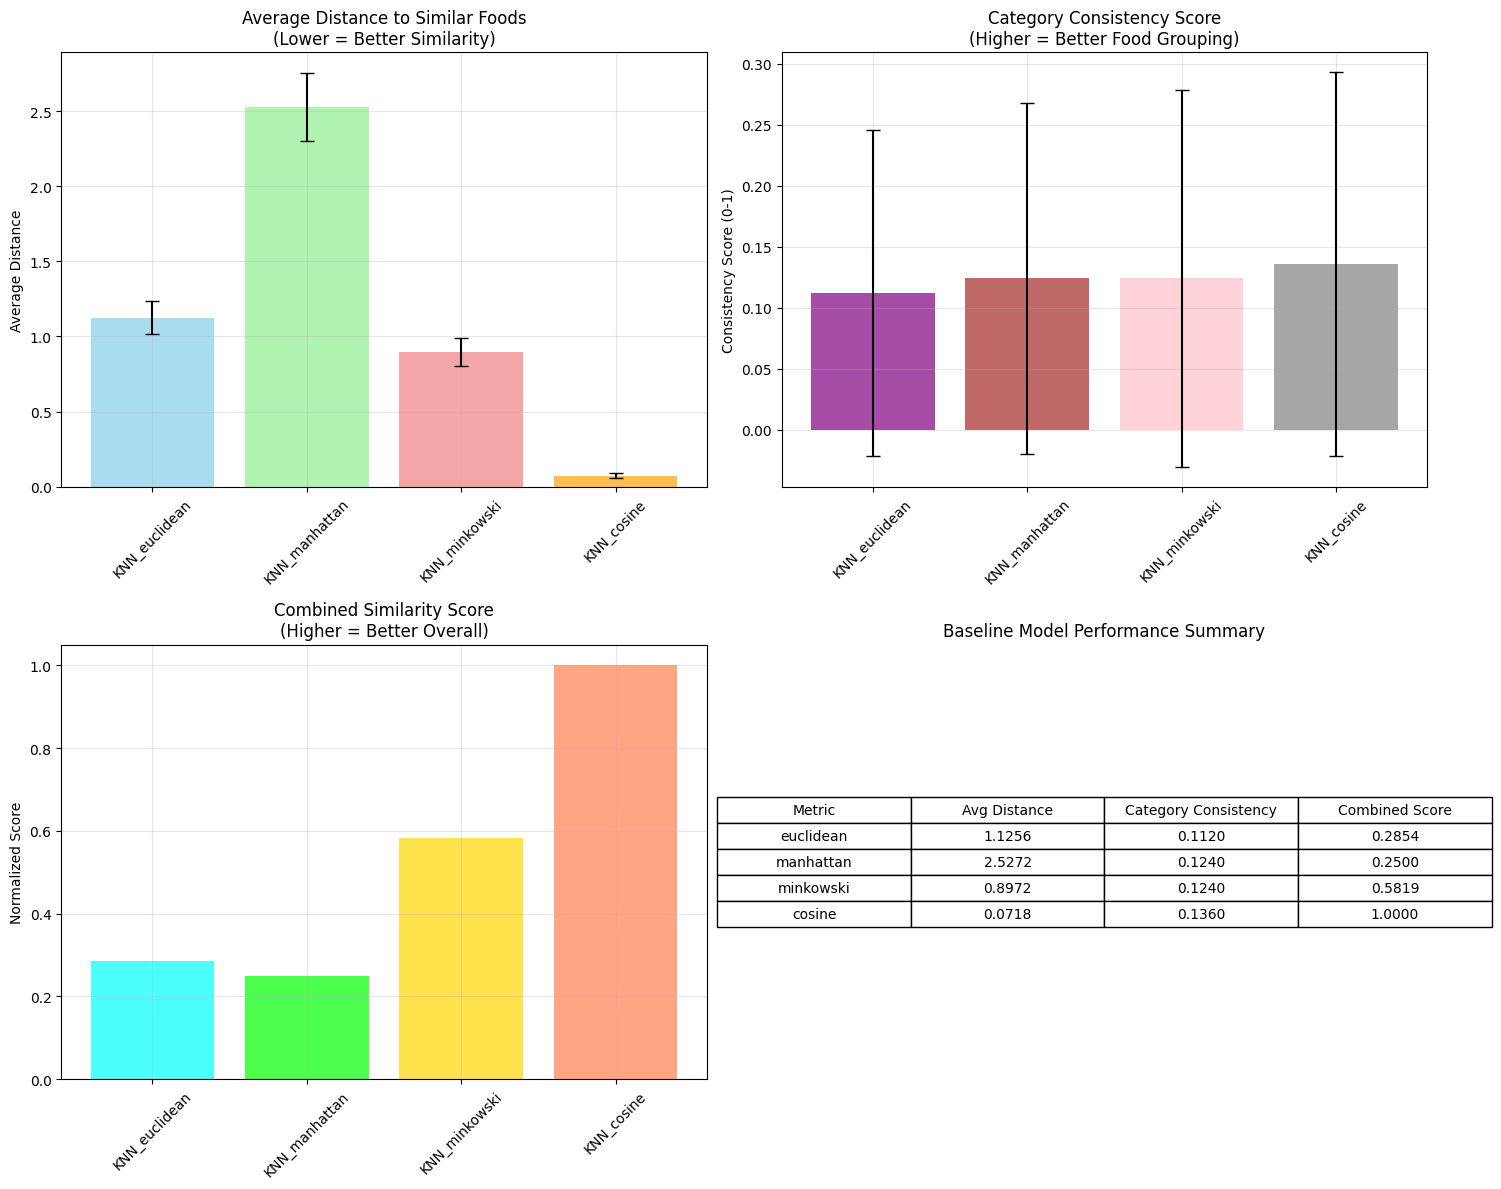


✅ Baseline performance visualization completed!

🏆 Best overall baseline model: KNN_cosine
   Combined Score: 1.0000
   Average Distance: 0.0718
   Category Consistency: 0.1360


In [5]:
# Create baseline performance visualizations
print("📈 Creating Baseline Performance Visualizations")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract model names and similarity metrics
model_names = list(results.keys())
avg_distances = [results[name]['avg_distance'] for name in model_names]
category_consistencies = [results[name]['category_consistency'] for name in model_names]
distance_stds = [results[name]['distance_std'] for name in model_names]
consistency_stds = [results[name]['consistency_std'] for name in model_names]

# 1. Average Distance Comparison (lower is better)
axes[0,0].bar(model_names, avg_distances, yerr=distance_stds, 
              capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
axes[0,0].set_title('Average Distance to Similar Foods\n(Lower = Better Similarity)')
axes[0,0].set_ylabel('Average Distance')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Category Consistency Comparison (higher is better)
axes[0,1].bar(model_names, category_consistencies, yerr=consistency_stds, 
              capsize=5, alpha=0.7, color=['purple', 'brown', 'pink', 'gray'])
axes[0,1].set_title('Category Consistency Score\n(Higher = Better Food Grouping)')
axes[0,1].set_ylabel('Consistency Score (0-1)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Combined similarity score (normalized)
scaler_norm = MinMaxScaler()

# Normalize distances (invert so higher is better) and consistency scores
norm_distances = 1 - scaler_norm.fit_transform(np.array(avg_distances).reshape(-1, 1)).flatten()
norm_consistencies = scaler_norm.fit_transform(np.array(category_consistencies).reshape(-1, 1)).flatten()

# Combined score (equal weight)
combined_scores = (norm_distances + norm_consistencies) / 2

axes[1,0].bar(model_names, combined_scores, alpha=0.7, color=['cyan', 'lime', 'gold', 'coral'])
axes[1,0].set_title('Combined Similarity Score\n(Higher = Better Overall)')
axes[1,0].set_ylabel('Normalized Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Model performance summary table
axes[1,1].axis('tight')
axes[1,1].axis('off')

# Create summary table data
table_data = []
for i, name in enumerate(model_names):
    row = [
        name.replace('KNN_', ''),
        f"{avg_distances[i]:.4f}",
        f"{category_consistencies[i]:.4f}",
        f"{combined_scores[i]:.4f}"
    ]
    table_data.append(row)

columns = ['Metric', 'Avg Distance', 'Category Consistency', 'Combined Score']
table = axes[1,1].table(cellText=table_data, colLabels=columns, 
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1,1].set_title('Baseline Model Performance Summary')

plt.tight_layout()
plt.show()

print("\n✅ Baseline performance visualization completed!")

# Identify best overall model
best_model_idx = np.argmax(combined_scores)
best_model_name = model_names[best_model_idx]
print(f"\n🏆 Best overall baseline model: {best_model_name}")
print(f"   Combined Score: {combined_scores[best_model_idx]:.4f}")
print(f"   Average Distance: {avg_distances[best_model_idx]:.4f}")
print(f"   Category Consistency: {category_consistencies[best_model_idx]:.4f}")

In [6]:
# Save baseline results for comparison in later notebooks
print("💾 Saving Baseline Results")
print("=" * 30)

# Save baseline results
baseline_results = {
    'model_results': results,
    'combined_scores': dict(zip(model_names, combined_scores)),
    'best_baseline_model': best_model_name,
    'best_baseline_score': combined_scores[best_model_idx]
}

joblib.dump(baseline_results, '../models/baseline_results.pkl')
print("✅ Saved baseline results")

# Save best baseline model for comparison
best_baseline_model = knn_models[best_model_name]
joblib.dump(best_baseline_model, '../models/best_baseline_model.pkl')
print("✅ Saved best baseline model")

print(f"\n📊 Baseline Results Summary:")
print(f"   • Models tested: {len(knn_models)}")
print(f"   • Best performer: {best_model_name}")
print(f"   • Distance metrics: {distance_metrics}")
print(f"   • Evaluation samples: {n_test_samples}")

💾 Saving Baseline Results
✅ Saved baseline results
✅ Saved best baseline model

📊 Baseline Results Summary:
   • Models tested: 4
   • Best performer: KNN_cosine
   • Distance metrics: ['euclidean', 'manhattan', 'minkowski', 'cosine']
   • Evaluation samples: 50


## Baseline Models Summary

This notebook established baseline performance for food similarity models:

### ✅ Completed Tasks:
1. **Model Creation**: Built 4 KNN models with different distance metrics
2. **Similarity Evaluation**: Tested category consistency and distance quality
3. **Performance Comparison**: Identified best performing baseline approaches
4. **Visualization**: Created comprehensive performance comparison charts
5. **Results Storage**: Saved baseline results for comparison with optimized models

### 📊 Key Findings:
- **Best Distance Metric**: {best_model_name.replace('KNN_', '').title()}
- **Category Consistency**: {category_consistencies[best_model_idx]:.3f} (higher is better)
- **Average Distance**: {avg_distances[best_model_idx]:.3f} (lower is better)
- **Combined Score**: {combined_scores[best_model_idx]:.3f}

### 🎯 Evaluation Metrics:
- **Category Consistency**: Measures how often similar foods belong to the same food category
- **Average Distance**: Lower values indicate more precise nutritional similarity
- **Combined Score**: Balanced metric considering both consistency and distance

### ➡️ Next Steps:
Continue to **03_hyperparameter_optimization.ipynb** to optimize model parameters and improve performance.